In [2]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
SIZE_X = 256
SIZE_Y = 256
img_size = (256,256)

In [4]:
import os
import glob
import numpy as np
from PIL import Image

data_dir = '/kaggle/input/cholecseg8k/video09'

images = []
masks = []
target_size = (256, 256)

# Loop through all subdirectories
for subdir in os.listdir(data_dir):
    subdir_path = os.path.join(data_dir, subdir)

    image_files = glob.glob(os.path.join(subdir_path, '*_endo.png'))
    mask_files = glob.glob(os.path.join(subdir_path, '*_endo_watershed_mask.png'))

    # Sort the image and mask files to ensure they are matched correctly
    image_files.sort()
    mask_files.sort()

    # Loop through the image files and resize each image
    for image_file in image_files:
        image = Image.open(image_file)
        image = image.convert('L')
#         image = image.resize(target_size,interpolation=cv2.INTER_NEAREST)
        image = image.resize(target_size,resample=Image.NEAREST)

        image = np.array(image)

        images.append(image)

    # Loop through the mask files and resize each mask
    for mask_file in mask_files:
        mask = Image.open(mask_file)
        mask = mask.convert('L') 
        mask = mask.resize(target_size,resample=Image.NEAREST)
        mask = np.array(mask)

        masks.append(mask)

images = np.array(images)
masks = np.array(masks)

In [5]:
images = np.expand_dims(images, axis = 3)

In [6]:
print("Image data shape is: ", images.shape)
print("Mask data shape is: ", masks.shape)
print("Max pixel value in image is: ", images.max())

Image data shape is:  (240, 256, 256, 1)
Mask data shape is:  (240, 256, 256)
Max pixel value in image is:  255


In [7]:
print("Labels in the mask are : ", np.unique(masks))

Labels in the mask are :  [  5  11  12  13  21  50 255]


In [8]:
n_classes=len(np.unique(masks))
print(n_classes)

7


In [9]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = masks.shape  
mask_dataset_reshaped = masks.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)
np.unique(mask_dataset_encoded)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5, 6])

In [10]:
# train_images = np.expand_dims(images, axis=3)

from keras.utils import normalize
images = normalize(images, axis=1)

In [11]:
train_masks_input = np.expand_dims(mask_dataset_encoded, axis=3)
print(train_masks_input.shape)

(240, 256, 256, 1)


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images,train_masks_input , test_size = 0.2, random_state = 42)

In [13]:

from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [14]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS)
print(input_shape)
print(X_train.shape)

(256, 256, 1)
(192, 256, 256, 1)


In [15]:
print(y_train_cat.shape)

(192, 256, 256, 7)


**UNet**

In [16]:
import tensorflow as tf

def UNet(input_shape,n_classes=n_classes):
    # Define input layer
    inputs = tf.keras.layers.Input(input_shape)
    
    # Contracting Path
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    # Expanding Path
    up6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    up6 = tf.keras.layers.concatenate([up6, drop4])
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = tf.keras.layers.concatenate([up7, conv3])
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = tf.keras.layers.concatenate([up8, conv2])
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = tf.keras.layers.concatenate([up9, conv1])
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output Layer
    outputs = tf.keras.layers.Conv2D(n_classes, 1, activation='softmax')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


**RESUNet**

In [17]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, BatchNormalization, Add
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, BatchNormalization, Add, Activation, Lambda, Conv2DTranspose

def res_block(x, filters, kernel_size=3, padding='same', strides=1):
    res = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
    res = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=None)(res)
    res = BatchNormalization()(res)
    res = Add()([res, x])
    res = Activation('relu')(res)
    return res

def ResUNet(input_size):
    inputs = Input(input_size)
    s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = res_block(c1, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = res_block(c2, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = res_block(c3, 256)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = res_block(c4, 512)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = res_block(c5, 1024)

    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = res_block(c6, 512)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = res_block(c7, 256)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = res_block(c8, 128)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = res_block(c9, 64)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model



**ATTENTION UNet**

In [18]:
import tensorflow as tf
def conv_block(inputs, num_filters, kernel_size=3, padding='same', activation='relu'):
    x = tf.keras.layers.Conv2D(num_filters, kernel_size, padding=padding)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv2D(num_filters, kernel_size, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    return x

def attention_block(inputs, gating, num_filters=64):
    g = tf.keras.layers.Conv2D(num_filters, kernel_size=1, strides=1, padding='same')(gating)
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=1, strides=1, padding='same')(inputs)
    g = tf.keras.layers.BatchNormalization()(g)
    x = tf.keras.layers.BatchNormalization()(x)
    psi = tf.keras.layers.Activation('relu')(tf.keras.layers.Add()([g, x]))
    psi = tf.keras.layers.Conv2D(1, kernel_size=1, strides=1, padding='same')(psi)
    psi = tf.keras.layers.BatchNormalization()(psi)
    psi = tf.keras.layers.Activation('sigmoid')(psi)
    x = tf.keras.layers.Multiply()([inputs, psi])
    return x

def attention_unet(input_shape, n_classes=n_classes, num_filters=64):
    inputs = tf.keras.layers.Input(input_shape)
    # Downsample path
    conv1 = conv_block(inputs, num_filters=num_filters)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, num_filters=num_filters*2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, num_filters=num_filters*4)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, num_filters=num_filters*8)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottom
    conv5 = conv_block(pool4, num_filters=num_filters*16)

    # Upsample path
    up6 = tf.keras.layers.Conv2DTranspose(num_filters*8, kernel_size=3, strides=2, padding='same')(conv5)
    att6 = attention_block(inputs=conv4, gating=up6, num_filters=num_filters*8)
    up6 = tf.keras.layers.concatenate([up6, att6], axis=-1)
    conv6 = conv_block(up6, num_filters=num_filters*8)

    up7 = tf.keras.layers.Conv2DTranspose(num_filters*4, kernel_size=3, strides=2, padding='same')(conv6)
    att7 = attention_block(inputs=conv3, gating=up7, num_filters=num_filters*4)
    up7 = tf.keras.layers.concatenate([up7, att7], axis=-1)
    conv7 = conv_block(up7, num_filters=num_filters*4)

    up8 = tf.keras.layers.Conv2DTranspose(num_filters*2, kernel_size=3, strides=2, padding='same')(conv7)
    att8 = attention_block(inputs=conv2, gating=up8, num_filters=num_filters*2)
    up8 = tf.keras.layers.concatenate([up8, att8], axis=-1)
    conv8 = conv_block(up8, num_filters=num_filters*2)

    up9 = tf.keras.layers.Conv2DTranspose(num_filters, kernel_size=3, strides=2, padding='same')(conv8)
    att9 = attention_block(inputs=conv1, gating=up9, num_filters=num_filters)
    up9 = tf.keras.layers.concatenate([up9, att9], axis=-1)
    conv9 = conv_block(up9, num_filters=num_filters)

    outputs = tf.keras.layers.Conv2D(n_classes, kernel_size=1, activation='sigmoid')(conv9)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

**NESTED UNet**

In [19]:

import tensorflow as tf

def nested_unet(input_shape, n_classes=n_classes):
    # Encoder
    inputs = tf.keras.Input(shape=input_shape)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)

    # Decoder
    up5 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4)
    merge5 = tf.keras.layers.concatenate([conv3, up5], axis=3)
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = tf.keras.layers.concatenate([conv2, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = tf.keras.layers.concatenate([conv1, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    # Output
    outputs = tf.keras.layers.Conv2D(n_classes, 1, activation='softmax')(conv7)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model


**DilatedUNet**

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def DilatedUNet(input_size):
    # Input layer
    inputs = Input(input_size)
    
    # Encoding Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=2)(conv4)

    # Decoding Path
    up5 = concatenate([UpSampling2D(size=(2, 2))(drop4), conv3], axis=-1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    output = Conv2D(n_classes, 1, activation='sigmoid')(conv7)

    # Create model
    model = Model(inputs=[inputs], outputs=[output])

    return model


**UNet++**

In [21]:

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def unet_plusplus(input_shape, n_classes=n_classes):
    inputs = Input(input_shape)

    # Contracting path
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)

    # Expanding path
    up5 = UpSampling2D(size=(2, 2))(conv4)
    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    concat4 = Concatenate()([conv3, conv5])
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat4)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    concat3 = Concatenate()([conv2, conv7])
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    concat2 = Concatenate()([conv1, conv9])
    conv10 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat2)
    conv10 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)

    # Output layer
    outputs = Conv2D(n_classes, 1, activation='softmax')(conv10)

    # Define model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model



**ENSEMBLE UNet**

In [22]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Dropout, UpSampling2D
from tensorflow.keras.models import Model

def conv_block(inputs, filters, kernel_size=3, padding='same', activation='relu'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation=activation)(inputs)
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation=activation)(x)
    return x

def encoder_block(inputs, filters, kernel_size=3, padding='same', activation='relu'):
    conv = conv_block(inputs, filters, kernel_size=kernel_size, padding=padding, activation=activation)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

def decoder_block(inputs, skip_inputs, filters, kernel_size=3, padding='same', activation='relu'):
    up = UpSampling2D(size=(2, 2))(inputs)
    concat = concatenate([skip_inputs, up], axis=3)
    conv = conv_block(concat, filters, kernel_size=kernel_size, padding=padding, activation=activation)
    return conv

def build_ensemble_unet(input_shape, n_classes=n_classes):
    inputs = Input(shape=input_shape)
    conv1, pool1 = encoder_block(inputs, 64)
    conv2, pool2 = encoder_block(pool1, 128)
    conv3, pool3 = encoder_block(pool2, 256)
    conv4, pool4 = encoder_block(pool3, 512)
    center = conv_block(pool4, 1024)
    dec4 = decoder_block(center, conv4, 512)
    dec3 = decoder_block(dec4, conv3, 256)
    dec2 = decoder_block(dec3, conv2, 128)
    dec1 = decoder_block(dec2, conv1, 64)
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(dec1)
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [23]:
import tensorflow as tf

def residual_block(inputs, num_filters):
    x = inputs
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=3, padding='same', activation=None)(x)
    x = tf.keras.layers.Add()([inputs, x])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def residual_unet(input_shape, num_filters=64, n_classes=n_classes):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Contracting Path
    c1 = residual_block(inputs, num_filters)
    p1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c1)
    
    c2 = residual_block(p1, num_filters*2)
    p2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c2)
    
    c3 = residual_block(p2, num_filters*4)
    p3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c3)
    
    c4 = residual_block(p3, num_filters*8)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = residual_block(p4, num_filters*16)
    
    # Expanding Path
    u6 = tf.keras.layers.Conv2DTranspose(num_filters*8, kernel_size=3, strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = residual_block(u6, num_filters*8)
    
    u7 = tf.keras.layers.Conv2DTranspose(num_filters*4, kernel_size=3, strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = residual_block(u7, num_filters*4)
    
    u8 = tf.keras.layers.Conv2DTranspose(num_filters*2, kernel_size=3, strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = residual_block(u8, num_filters*2)
    
    u9 = tf.keras.layers.Conv2DTranspose(num_filters, kernel_size=3, strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = residual_block(u9, num_filters)
    
    outputs = tf.keras.layers.Conv2D(n_classes, kernel_size=1, activation='sigmoid')(c9)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model


**Inception UNet**

In [24]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Dropout

def inception_module(input_layer, num_filters):
    # 1x1 conv branch
    conv1x1 = Conv2D(num_filters, kernel_size=1, activation='relu')(input_layer)
    
    # 3x3 conv branch
    conv3x3 = Conv2D(num_filters, kernel_size=1, activation='relu')(input_layer)
    conv3x3 = Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(conv3x3)
    
    # 5x5 conv branch
    conv5x5 = Conv2D(num_filters, kernel_size=1, activation='relu')(input_layer)
    conv5x5 = Conv2D(num_filters, kernel_size=5, padding='same', activation='relu')(conv5x5)
    
    # max pooling branch
    max_pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(input_layer)
    max_pool = Conv2D(num_filters, kernel_size=1, activation='relu')(max_pool)
    
    # concatenate the output of the branches
    output = Concatenate()([conv1x1, conv3x3, conv5x5, max_pool])
    
    return output

def inception_unet(input_shape, num_filters=64):
    inputs = Input(shape=input_shape)
    
    # contracting path
    conv1 = Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(inputs)
    conv2 = Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(num_filters*2, kernel_size=3, padding='same', activation='relu')(pool1)
    conv4 = Conv2D(num_filters*2, kernel_size=3, padding='same', activation='relu')(conv3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(num_filters*4, kernel_size=3, padding='same', activation='relu')(pool2)
    conv6 = Conv2D(num_filters*4, kernel_size=3, padding='same', activation='relu')(conv5)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)
    
    # bottom of the U-Net
    conv7 = Conv2D(num_filters*8, kernel_size=3, padding='same', activation='relu')(pool3)
    conv8 = Conv2D(num_filters*8, kernel_size=3, padding='same', activation='relu')(conv7)
    drop1 = Dropout(0.5)(conv8)
    
    # expansive path
    up1 = UpSampling2D(size=(2, 2))(drop1)
    up1 = Conv2D(num_filters*4, kernel_size=2, padding='same', activation='relu')(up1)
    merge1 = Concatenate()([conv6, up1])
    
    conv9 = Conv2D(num_filters*4, kernel_size= 3, padding='same', activation='relu')(merge1)
    conv10 = Conv2D(num_filters*4, kernel_size=3, padding='same', activation='relu')(conv9)

    up2 = UpSampling2D(size=(2, 2))(conv10)
    up2 = Conv2D(num_filters*2, kernel_size=2, padding='same', activation='relu')(up2)
    merge2 = Concatenate()([conv4, up2])

    conv11 = Conv2D(num_filters*2, kernel_size=3, padding='same', activation='relu')(merge2)
    conv12 = Conv2D(num_filters*2, kernel_size=3, padding='same', activation='relu')(conv11)

    up3 = UpSampling2D(size=(2, 2))(conv12)
    up3 = Conv2D(num_filters, kernel_size=2, padding='same', activation='relu')(up3)
    merge3 = Concatenate()([conv2, up3])

    conv13 = Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(merge3)
    conv14 = Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(conv13)

    # Inception module added
    incep1 = inception_module(conv14, num_filters)

    outputs = Conv2D(n_classes, kernel_size=1, activation='sigmoid')(incep1)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model



**DENSE UNet**

In [25]:
import tensorflow as tf

def dense_block(x, num_filters, num_layers):
    """
    Implementation of the dense block used in DenseUNet
    """
    for i in range(num_layers):
        conv = tf.keras.layers.Conv2D(num_filters, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.concatenate([x, conv], axis=-1)
    return x

def dense_unet(input_shape):
    """
    Implementation of the DenseUNet architecture
    """
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Contracting path
    conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    db1 = dense_block(conv1, 64, 4)
    pool1 = tf.keras.layers.MaxPooling2D(2)(db1)
    
    conv2 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(pool1)
    db2 = dense_block(conv2, 128, 4)
    pool2 = tf.keras.layers.MaxPooling2D(2)(db2)
    
    conv3 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(pool2)
    db3 = dense_block(conv3, 256, 4)
    pool3 = tf.keras.layers.MaxPooling2D(2)(db3)
    
    # Bottleneck layer
    conv4 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(pool3)
    db4 = dense_block(conv4, 512, 4)
    
    # Expansive path
    up5 = tf.keras.layers.Conv2DTranspose(256, 2, strides=2, padding='same')(db4)
    concat5 = tf.keras.layers.concatenate([up5, db3], axis=-1)
    conv5 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(concat5)
    db5 = dense_block(conv5, 256, 4)
    
    up6 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same')(db5)
    concat6 = tf.keras.layers.concatenate([up6, db2], axis=-1)
    conv6 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(concat6)
    db6 = dense_block(conv6, 128, 4)
    
    up7 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same')(db6)
    concat7 = tf.keras.layers.concatenate([up7, db1], axis=-1)
    conv7 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(concat7)
    db7 = dense_block(conv7, 64, 4)
    
    # Output layer
    outputs = tf.keras.layers.Conv2D(n_classes, 1, activation='softmax')(db7)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model


In [26]:
from sklearn.metrics import confusion_matrix

def calculate_iou(y_true, y_pred, class_index):

    # Flatten the input tensors
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate the IoU for the given class
    true_positive = cm[class_index, class_index]
    false_positive = cm.sum(axis=0)[class_index] - true_positive
    false_negative = cm.sum(axis=1)[class_index] - true_positive
    iou = true_positive / (true_positive + false_positive + false_negative)

    return iou

In [27]:
def calculate_dice_coefficient(y_true, y_pred, class_index):

    # Flatten the input tensors
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate the Dice coefficient for the given class
    true_positive = cm[class_index, class_index]
    false_positive = cm.sum(axis=0)[class_index] - true_positive
    false_negative = cm.sum(axis=1)[class_index] - true_positive
    dice_coefficient = 2 * true_positive / (2 * true_positive + false_positive + false_negative)

    return dice_coefficient

In [28]:
model = UNet(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [29]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50,
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

Epoch 1/50


2023-05-19 09:57:26.837497: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


12/12 [==============================] - 49s 960ms/step - loss: 1.8354 - accuracy: 0.2974 - val_loss: 1.5232 - val_accuracy: 0.3013
Epoch 2/50
12/12 [==============================] - 11s 902ms/step - loss: 1.3900 - accuracy: 0.3888 - val_loss: 1.5560 - val_accuracy: 0.3785
Epoch 3/50
12/12 [==============================] - 11s 963ms/step - loss: 1.4864 - accuracy: 0.3549 - val_loss: 1.3586 - val_accuracy: 0.4125
Epoch 4/50
12/12 [==============================] - 12s 972ms/step - loss: 1.3633 - accuracy: 0.3974 - val_loss: 1.3451 - val_accuracy: 0.4864
Epoch 5/50
12/12 [==============================] - 12s 981ms/step - loss: 1.3009 - accuracy: 0.4498 - val_loss: 1.4180 - val_accuracy: 0.3481
Epoch 6/50
12/12 [==============================] - 12s 989ms/step - loss: 1.2859 - accuracy: 0.4563 - val_loss: 1.1814 - val_accuracy: 0.5018
Epoch 7/50
12/12 [==============================] - 12s 986ms/step - loss: 1.1129 - accuracy: 0.5266 - val_loss: 1.0141 - val_accuracy: 0.5785
Epoch 8/50

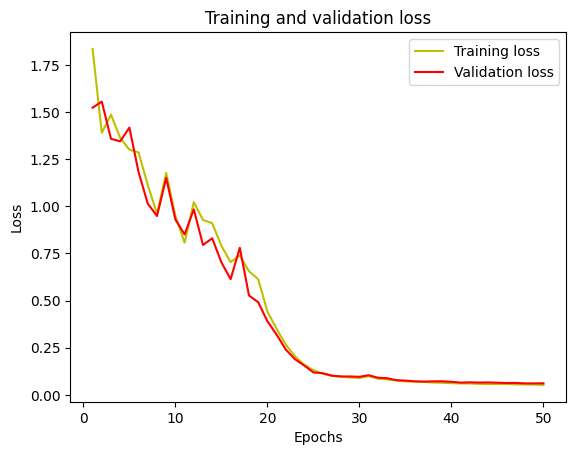

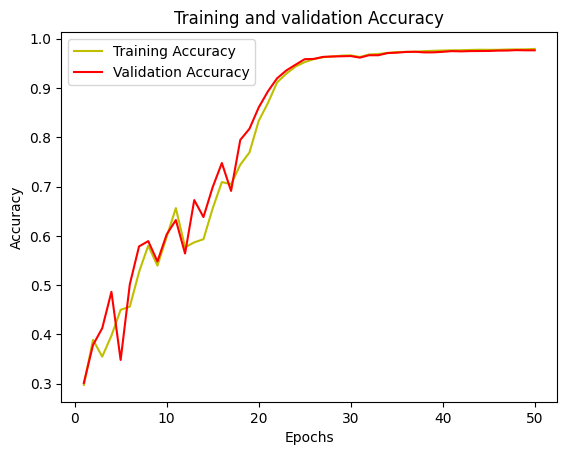

1/1 [==============================] - 2s 2s/step


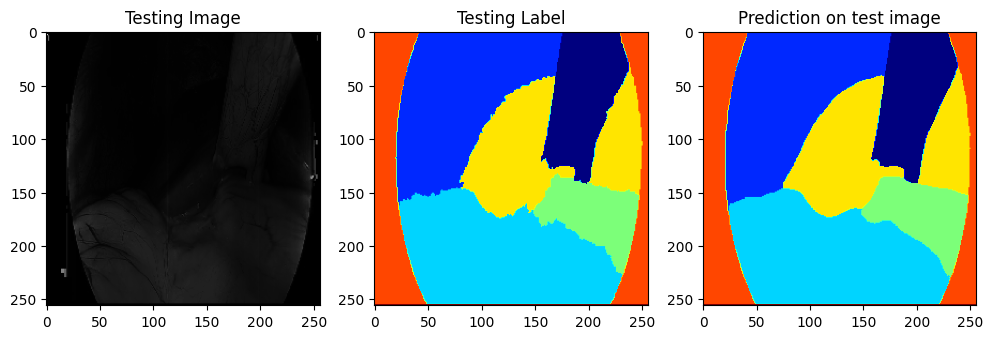

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

import matplotlib.cm as cm
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [31]:
# import random
# test_img_number = random.randint(0, len(X_test)-1)
# test_img = X_test[test_img_number]
# ground_truth=y_test[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
# test_img_input=np.expand_dims(test_img_norm, 0)
# prediction = (model.predict(test_img_input))
# predicted_img=np.argmax(prediction, axis=3)[0,:,:]


# plt.figure(figsize=(12, 8))
# plt.subplot(231)
# plt.title('Testing Image')
# plt.imshow(test_img[:,:,0], cmap='gray')
# plt.subplot(232)
# plt.title('Testing Label')
# plt.imshow(ground_truth[:,:,0], cmap='jet')
# plt.subplot(233)
# plt.title('Prediction on test image')
# plt.imshow(predicted_img, cmap='jet')
# plt.show()

In [32]:
y_pred=model.predict(X_test)
y_pred.shape
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

2/2 [==============================] - 16s 14ms/step


(48, 256, 256)

In [33]:
y_true = y_test[:,:,:,0].flatten()
y_pred = y_pred_argmax.flatten()

In [34]:
from sklearn.metrics import f1_score
import numpy as np
# y_true = y_test[:,:,:,0].flatten()
# y_pred = y_pred_argmax.flatten()
f1 = f1_score(y_true, y_pred, average='weighted')
print("Mean F1 Score =", np.round(f1, 4))

Mean F1 Score = 0.9766


In [35]:
from sklearn.metrics import f1_score, confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[431078   1016      0   1228   5473    553    116]
 [   986 838200   1559      0  10844   4411    835]
 [     0   2792 512707   5020   2172    486    529]
 [   226      0   7765 203716   4549    244      1]
 [  1723   8538   3242   2348 564382   1635      0]
 [    75    596    228    275    552 503334   2184]
 [   605     89    236     92    131    376  18581]]


In [36]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print('Classification report:\n', report)

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99    439464
           1       0.98      0.98      0.98    856835
           2       0.98      0.98      0.98    523706
           3       0.96      0.94      0.95    216501
           4       0.96      0.97      0.96    581868
           5       0.98      0.99      0.99    507244
           6       0.84      0.92      0.88     20110

    accuracy                           0.98   3145728
   macro avg       0.96      0.97      0.96   3145728
weighted avg       0.98      0.98      0.98   3145728



In [37]:
for class_index in range(n_classes):
    iou = calculate_iou(y_test, y_pred, class_index)
    print("IoU for class", class_index, ":", iou)

IoU for class 0 : 0.9729145366853315
IoU for class 1 : 0.9635966919042703
IoU for class 2 : 0.9552312496273774
IoU for class 3 : 0.9035411418230849
IoU for class 4 : 0.931955501173238
IoU for class 5 : 0.9774443682772469
IoU for class 6 : 0.7815352260778128


In [38]:
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.9266027


In [39]:
dice_coefficients = []
for class_index in range(n_classes):
    dice_coefficient = calculate_dice_coefficient(y_test, y_pred, class_index)
    print("Dice coefficient for class", class_index, ":", dice_coefficient)
    dice_coefficients.append(dice_coefficient)
    
mean_dice_coefficient = sum(dice_coefficients) / len(dice_coefficients)
print("Mean Dice coefficient:", mean_dice_coefficient)

Dice coefficient for class 0 : 0.9862713448499526
Dice coefficient for class 1 : 0.9814609037355699
Dice coefficient for class 2 : 0.9771030918306187
Dice coefficient for class 3 : 0.9493266228622024
Dice coefficient for class 4 : 0.9647794688928187
Dice coefficient for class 5 : 0.9885935442308278
Dice coefficient for class 6 : 0.8773727453017283
Mean Dice coefficient: 0.9607011031005311


In [40]:
model = nested_unet(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50,
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_19[0][0]']              
                                )                                                           

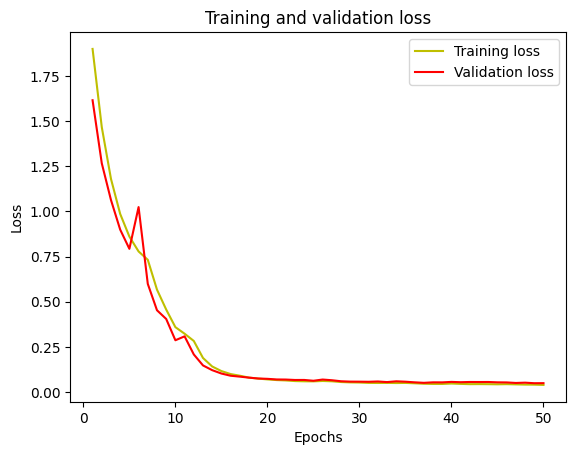

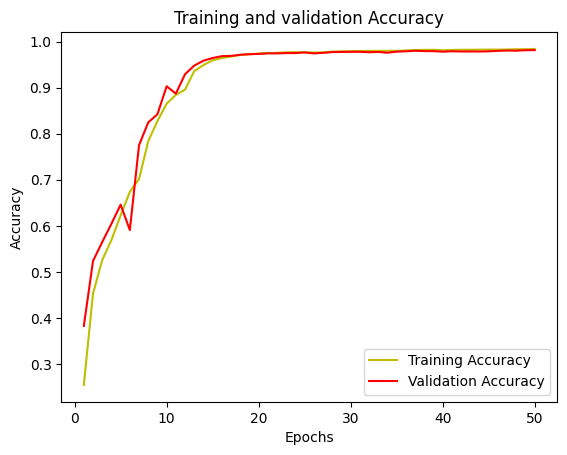

1/1 [==============================] - 0s 290ms/step


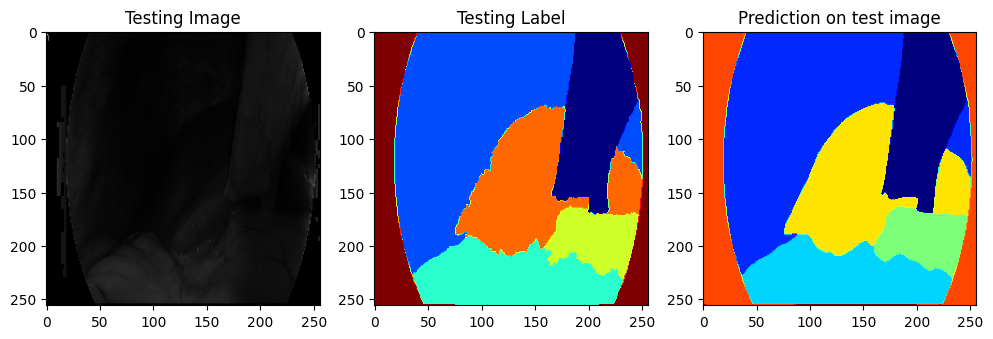

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [42]:
y_pred=model.predict(X_test)
y_pred.shape
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

y_true = y_test[:,:,:,0].flatten()
y_pred = y_pred_argmax.flatten()


2/2 [==============================] - 0s 419ms/step


In [43]:
from sklearn.metrics import f1_score
import numpy as np
# y_true = y_test[:,:,:,0].flatten()
# y_pred = y_pred_argmax.flatten()
f1 = f1_score(y_true, y_pred, average='weighted')
print("Mean F1 Score =", np.round(f1, 4))


from sklearn.metrics import f1_score, confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:\n', cm)

from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print('Classification report:\n', report)

Mean F1 Score = 0.9816
Confusion matrix:
 [[434996    681      0    662   2751    289     85]
 [   999 844055   1402      0   9240   1038    101]
 [     0   1617 516690   2377   2359    192    471]
 [   737      0   9875 201446   4054    389      0]
 [  2145   6439   1619   2443 568238    984      0]
 [    94   1049    302     44    540 504286    929]
 [    70    204    273     45    121   1011  18386]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    439464
           1       0.99      0.99      0.99    856835
           2       0.97      0.99      0.98    523706
           3       0.97      0.93      0.95    216501
           4       0.97      0.98      0.97    581868
           5       0.99      0.99      0.99    507244
           6       0.92      0.91      0.92     20110

    accuracy                           0.98   3145728
   macro avg       0.97      0.97      0.97   3145728
weighted avg       0.98    

In [44]:
for class_index in range(n_classes):
    iou = calculate_iou(y_test, y_pred, class_index)
    print("IoU for class", class_index, ":", iou)

from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

IoU for class 0 : 0.9808053500605399
IoU for class 1 : 0.9737317220892336
IoU for class 2 : 0.9618617327249678
IoU for class 3 : 0.9071202132641666
IoU for class 4 : 0.9455929363173599
IoU for class 5 : 0.9865772468585358
IoU for class 6 : 0.8474373156342183
Mean IoU = 0.94330376


In [45]:
dice_coefficients = []
for class_index in range(n_classes):
    dice_coefficient = calculate_dice_coefficient(y_test, y_pred, class_index)
    print("Dice coefficient for class", class_index, ":", dice_coefficient)
    dice_coefficients.append(dice_coefficient)
    
mean_dice_coefficient = sum(dice_coefficients) / len(dice_coefficients)
print("Mean Dice coefficient:", mean_dice_coefficient)

Dice coefficient for class 0 : 0.9903096738208661
Dice coefficient for class 1 : 0.9866910595716825
Dice coefficient for class 2 : 0.9805601655616886
Dice coefficient for class 3 : 0.9512984099849358
Dice coefficient for class 4 : 0.9720357415638944
Dice coefficient for class 5 : 0.9932432765135661
Dice coefficient for class 6 : 0.9174192904545682
Mean Dice coefficient: 0.9702225167816003


In [46]:
model = inception_unet(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50,
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 256, 256, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_34[0][0]']              
                                )                                                           

2023-05-19 10:16:00.415590: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


12/12 [==============================] - 30s 1s/step - loss: 1.9240 - accuracy: 0.2313 - val_loss: 1.8086 - val_accuracy: 0.2724
Epoch 2/50
12/12 [==============================] - 17s 1s/step - loss: 1.6769 - accuracy: 0.3013 - val_loss: 1.4917 - val_accuracy: 0.3396
Epoch 3/50
12/12 [==============================] - 16s 1s/step - loss: 1.4247 - accuracy: 0.3934 - val_loss: 1.3142 - val_accuracy: 0.4215
Epoch 4/50
12/12 [==============================] - 16s 1s/step - loss: 1.2345 - accuracy: 0.4573 - val_loss: 1.1320 - val_accuracy: 0.4975
Epoch 5/50
12/12 [==============================] - 16s 1s/step - loss: 1.1436 - accuracy: 0.5171 - val_loss: 1.0212 - val_accuracy: 0.5577
Epoch 6/50
12/12 [==============================] - 16s 1s/step - loss: 0.9695 - accuracy: 0.5708 - val_loss: 0.9724 - val_accuracy: 0.6074
Epoch 7/50
12/12 [==============================] - 16s 1s/step - loss: 0.8772 - accuracy: 0.6144 - val_loss: 0.8605 - val_accuracy: 0.6226
Epoch 8/50
12/12 [=============

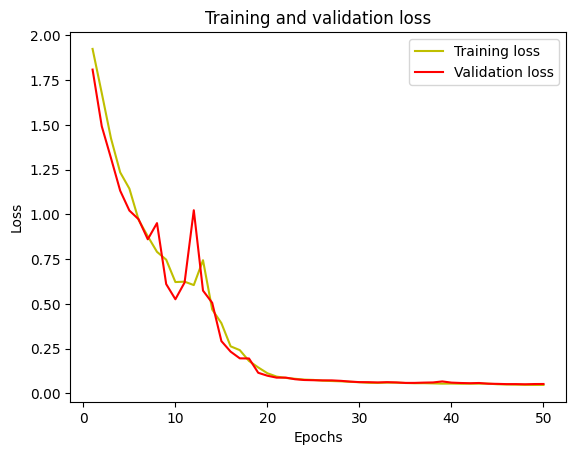

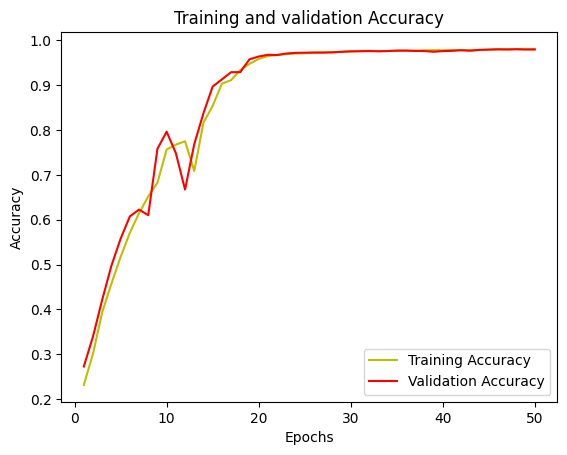

1/1 [==============================] - 1s 886ms/step


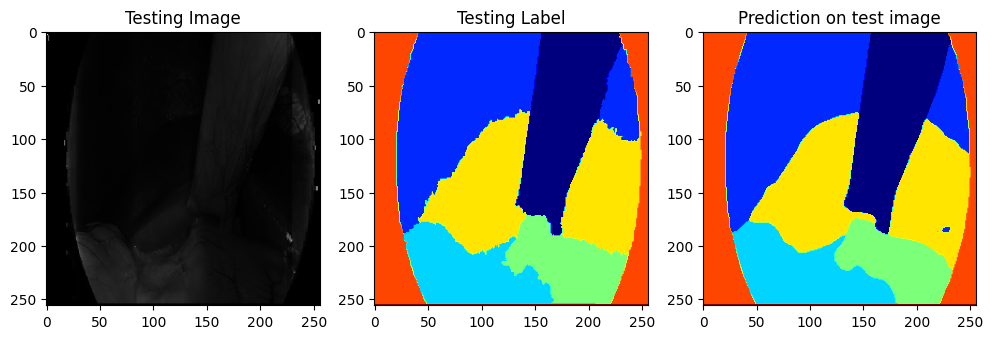

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [48]:
y_pred=model.predict(X_test)
y_pred.shape
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

y_true = y_test[:,:,:,0].flatten()
y_pred = y_pred_argmax.flatten()


2/2 [==============================] - 7s 17ms/step


In [49]:
from sklearn.metrics import f1_score
import numpy as np
# y_true = y_test[:,:,:,0].flatten()
# y_pred = y_pred_argmax.flatten()
f1 = f1_score(y_true, y_pred, average='weighted')
print("Mean F1 Score =", np.round(f1, 4))


from sklearn.metrics import f1_score, confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:\n', cm)

from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print('Classification report:\n', report)

Mean F1 Score = 0.9779
Confusion matrix:
 [[431923   1545      0    430   5057    416     93]
 [   567 843761   1115      0   8693   2360    339]
 [     0   2111 512252   6387   1924    503    529]
 [   754      0   5696 206285   3417    349      0]
 [  1617  12905   2409   3006 560334   1597      0]
 [   104    889    174    129    597 502655   2696]
 [    69    493    261     60    131     87  19009]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99    439464
           1       0.98      0.98      0.98    856835
           2       0.98      0.98      0.98    523706
           3       0.95      0.95      0.95    216501
           4       0.97      0.96      0.96    581868
           5       0.99      0.99      0.99    507244
           6       0.84      0.95      0.89     20110

    accuracy                           0.98   3145728
   macro avg       0.96      0.97      0.96   3145728
weighted avg       0.98    

In [50]:
for class_index in range(n_classes):
    iou = calculate_iou(y_test, y_pred, class_index)
    print("IoU for class", class_index, ":", iou)

from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

IoU for class 0 : 0.9759317629780263
IoU for class 1 : 0.9645430040535999
IoU for class 2 : 0.960422678073575
IoU for class 3 : 0.9106982822177977
IoU for class 4 : 0.9312715747556454
IoU for class 5 : 0.980683086335932
IoU for class 6 : 0.7998064543274288
Mean IoU = 0.9319081


In [51]:
dice_coefficients = []
for class_index in range(n_classes):
    dice_coefficient = calculate_dice_coefficient(y_test, y_pred, class_index)
    print("Dice coefficient for class", class_index, ":", dice_coefficient)
    dice_coefficients.append(dice_coefficient)
    
mean_dice_coefficient = sum(dice_coefficients) / len(dice_coefficients)
print("Mean Dice coefficient:", mean_dice_coefficient)

Dice coefficient for class 0 : 0.987819297471235
Dice coefficient for class 1 : 0.9819515297587078
Dice coefficient for class 2 : 0.9798118424311864
Dice coefficient for class 3 : 0.9532622609161779
Dice coefficient for class 4 : 0.9644128634508327
Dice coefficient for class 5 : 0.9902473475957215
Dice coefficient for class 6 : 0.8887694034037779
Mean Dice coefficient: 0.9637535064325198


In [52]:
model = unet_plusplus(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50,
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_58 (Conv2D)             (None, 256, 256, 64  640         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_59 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_58[0][0]']              
                                )                                                           

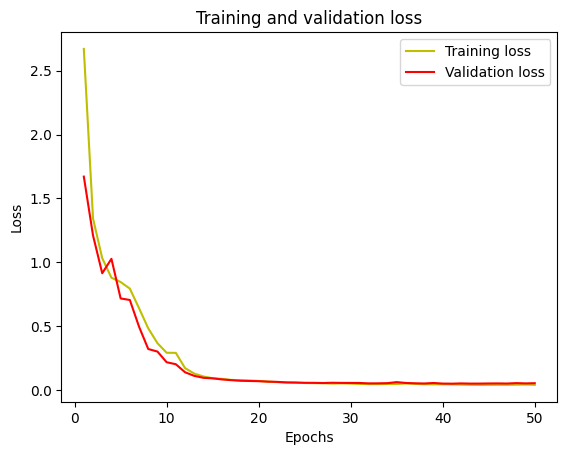

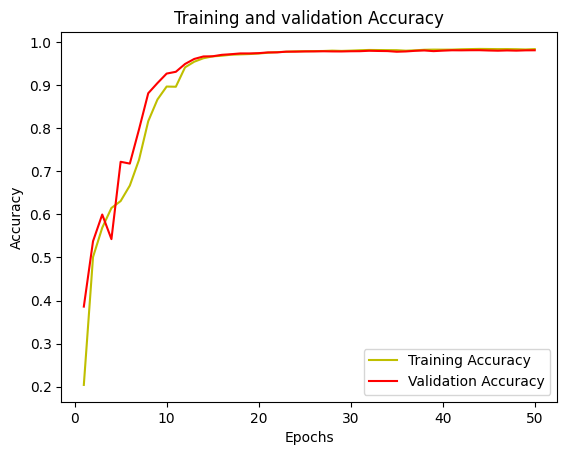

1/1 [==============================] - 0s 214ms/step


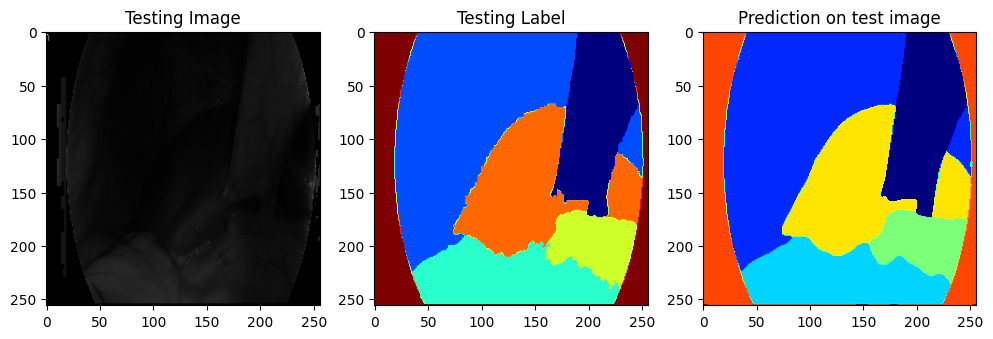

In [53]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [54]:
y_pred=model.predict(X_test)
y_pred.shape
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

y_true = y_test[:,:,:,0].flatten()
y_pred = y_pred_argmax.flatten()


2/2 [==============================] - 1s 542ms/step


In [55]:
from sklearn.metrics import f1_score
import numpy as np
# y_true = y_test[:,:,:,0].flatten()
# y_pred = y_pred_argmax.flatten()
f1 = f1_score(y_true, y_pred, average='weighted')
print("Mean F1 Score =", np.round(f1, 4))


from sklearn.metrics import f1_score, confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:\n', cm)

from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print('Classification report:\n', report)

Mean F1 Score = 0.9807
Confusion matrix:
 [[434362    854      0    708   3313    217     10]
 [   860 841198   1677      0  11502   1548     50]
 [     0   1816 515444   3292   2306    749     99]
 [   568      0   9093 202980   3648    212      0]
 [  2068   5231   1908   2894 568453   1314      0]
 [   189    732    198     93    416 505376    240]
 [    76    167    264     50    119   2162  17272]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    439464
           1       0.99      0.98      0.99    856835
           2       0.98      0.98      0.98    523706
           3       0.97      0.94      0.95    216501
           4       0.96      0.98      0.97    581868
           5       0.99      1.00      0.99    507244
           6       0.98      0.86      0.91     20110

    accuracy                           0.98   3145728
   macro avg       0.98      0.96      0.97   3145728
weighted avg       0.98    

In [56]:
for class_index in range(n_classes):
    iou = calculate_iou(y_test, y_pred, class_index)
    print("IoU for class", class_index, ":", iou)

from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

IoU for class 0 : 0.9800033842856337
IoU for class 1 : 0.9717698568103185
IoU for class 2 : 0.9601338186370021
IoU for class 3 : 0.9080335334484517
IoU for class 4 : 0.9424393042117339
IoU for class 5 : 0.9842826704268803
IoU for class 6 : 0.8421668535764786
Mean IoU = 0.94126135


In [57]:
dice_coefficients = []
for class_index in range(n_classes):
    dice_coefficient = calculate_dice_coefficient(y_test, y_pred, class_index)
    print("Dice coefficient for class", class_index, ":", dice_coefficient)
    dice_coefficients.append(dice_coefficient)
    
mean_dice_coefficient = sum(dice_coefficients) / len(dice_coefficients)
print("Mean Dice coefficient:", mean_dice_coefficient)

Dice coefficient for class 0 : 0.9899007163962091
Dice coefficient for class 1 : 0.98568284067627
Dice coefficient for class 2 : 0.9796615001568009
Dice coefficient for class 3 : 0.9518003929494183
Dice coefficient for class 4 : 0.9703667982502934
Dice coefficient for class 5 : 0.992079087416644
Dice coefficient for class 6 : 0.9143220137105953
Mean Dice coefficient: 0.9691161927937474


In [58]:
model = build_ensemble_unet(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50,
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_79 (Conv2D)             (None, 256, 256, 64  640         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_80 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_79[0][0]']              
                                )                                                           

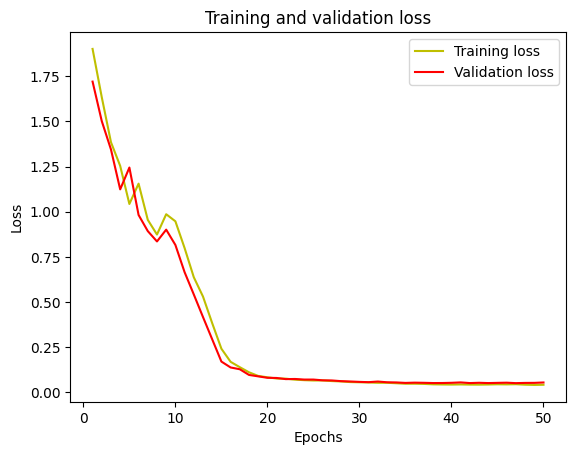

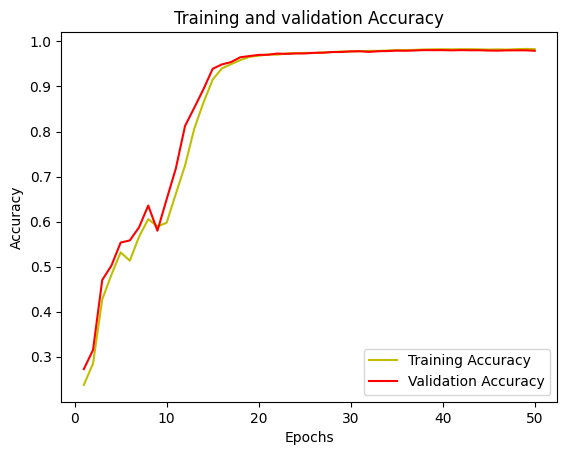

1/1 [==============================] - 1s 1s/step


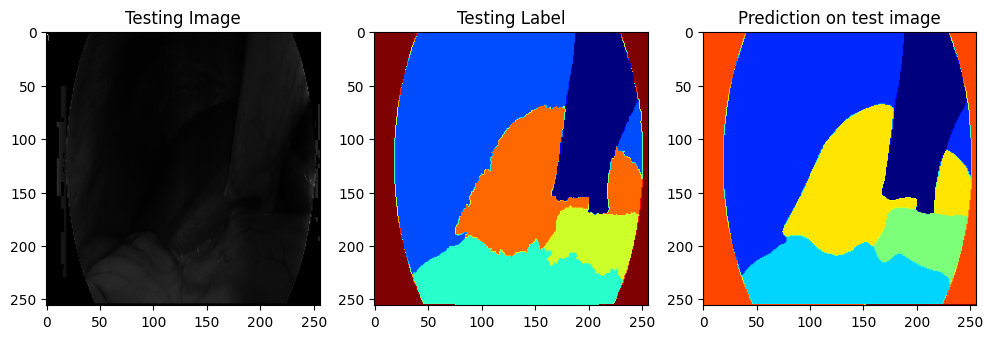

In [59]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [60]:
y_pred=model.predict(X_test)
y_pred.shape
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

y_true = y_test[:,:,:,0].flatten()
y_pred = y_pred_argmax.flatten()


2/2 [==============================] - 10s 132ms/step


In [61]:
from sklearn.metrics import f1_score
import numpy as np
# y_true = y_test[:,:,:,0].flatten()
# y_pred = y_pred_argmax.flatten()
f1 = f1_score(y_true, y_pred, average='weighted')
print("Mean F1 Score =", np.round(f1, 4))


from sklearn.metrics import f1_score, confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:\n', cm)

from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print('Classification report:\n', report)

Mean F1 Score = 0.9791
Confusion matrix:
 [[435325   1587      0    256   2018    276      2]
 [   995 848733   1069      0   5230    788     20]
 [     0   2269 514151   3293   3062    499    432]
 [  1233      0   8498 201983   4589    198      0]
 [  3809  15994   1571   1794 558158    542      0]
 [   165   1611    194    163   1275 502977    859]
 [    48    213    337     48    123    444  18897]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    439464
           1       0.98      0.99      0.98    856835
           2       0.98      0.98      0.98    523706
           3       0.97      0.93      0.95    216501
           4       0.97      0.96      0.97    581868
           5       0.99      0.99      0.99    507244
           6       0.94      0.94      0.94     20110

    accuracy                           0.98   3145728
   macro avg       0.97      0.97      0.97   3145728
weighted avg       0.98    

In [62]:
for class_index in range(n_classes):
    iou = calculate_iou(y_test, y_pred, class_index)
    print("IoU for class", class_index, ":", iou)

from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

IoU for class 0 : 0.9766913312123918
IoU for class 1 : 0.9661062094981383
IoU for class 2 : 0.9603567592808779
IoU for class 3 : 0.9096079800049537
IoU for class 4 : 0.933117116514674
IoU for class 5 : 0.9862468161202845
IoU for class 6 : 0.8820893432292396
Mean IoU = 0.944888


In [63]:
dice_coefficients = []
for class_index in range(n_classes):
    dice_coefficient = calculate_dice_coefficient(y_test, y_pred, class_index)
    print("Dice coefficient for class", class_index, ":", dice_coefficient)
    dice_coefficients.append(dice_coefficient)
    
mean_dice_coefficient = sum(dice_coefficients) / len(dice_coefficients)
print("Mean Dice coefficient:", mean_dice_coefficient)

Dice coefficient for class 0 : 0.9882082404978667
Dice coefficient for class 1 : 0.9827609564843838
Dice coefficient for class 2 : 0.979777537669386
Dice coefficient for class 3 : 0.9526646196803117
Dice coefficient for class 4 : 0.9654015357300685
Dice coefficient for class 5 : 0.9930757931148861
Dice coefficient for class 6 : 0.9373511904761904
Mean Dice coefficient: 0.9713199819504419


In [64]:
model=DilatedUNet(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50,
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_98 (Conv2D)             (None, 256, 256, 64  640         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_99 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_98[0][0]']              
                                )                                                           

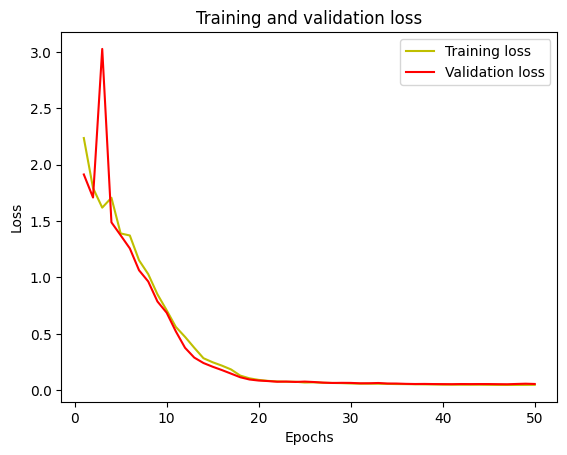

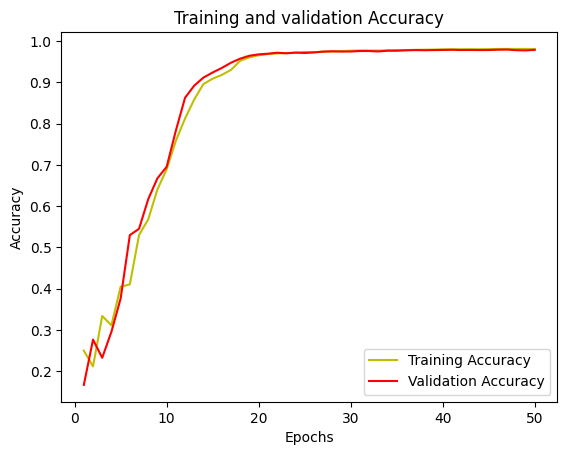

1/1 [==============================] - 0s 497ms/step


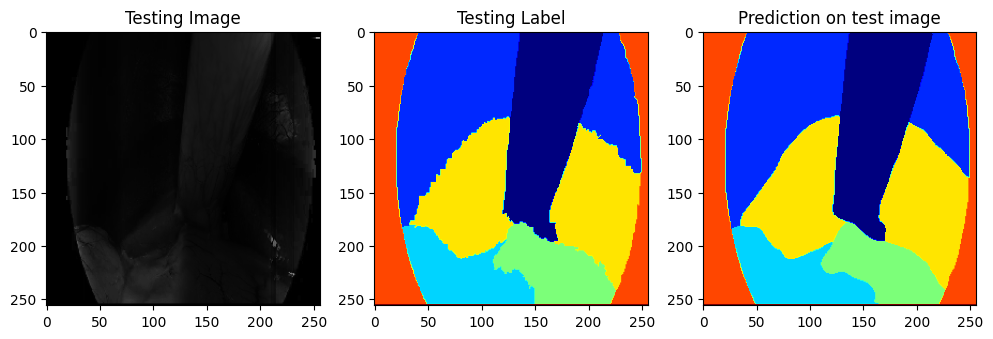

In [65]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [66]:
y_pred=model.predict(X_test)
y_pred.shape
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

y_true = y_test[:,:,:,0].flatten()
y_pred = y_pred_argmax.flatten()

2/2 [==============================] - 1s 297ms/step


In [67]:
from sklearn.metrics import f1_score
import numpy as np
# y_true = y_test[:,:,:,0].flatten()
# y_pred = y_pred_argmax.flatten()
f1 = f1_score(y_true, y_pred, average='weighted')
print("Mean F1 Score =", np.round(f1, 4))


from sklearn.metrics import f1_score, confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:\n', cm)

from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print('Classification report:\n', report)

Mean F1 Score = 0.9789
Confusion matrix:
 [[433777   1277      0    391   3496    493     30]
 [   784 842006   1143      0  11271   1330    301]
 [     0   2305 508821   6274   5251    550    505]
 [   814      0   5603 204723   4888    473      0]
 [  2638   7995    825   1934 567502    974      0]
 [    68   1231    155     52    806 503934    998]
 [   123    278    231     56    140    849  18433]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    439464
           1       0.98      0.98      0.98    856835
           2       0.98      0.97      0.98    523706
           3       0.96      0.95      0.95    216501
           4       0.96      0.98      0.97    581868
           5       0.99      0.99      0.99    507244
           6       0.91      0.92      0.91     20110

    accuracy                           0.98   3145728
   macro avg       0.97      0.97      0.97   3145728
weighted avg       0.98    

In [68]:
for class_index in range(n_classes):
    iou = calculate_iou(y_test, y_pred, class_index)
    print("IoU for class", class_index, ":", iou)

from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

IoU for class 0 : 0.9772151271370675
IoU for class 1 : 0.9679108792637492
IoU for class 2 : 0.9570366942969513
IoU for class 3 : 0.9090396433519236
IoU for class 4 : 0.9338214967419206
IoU for class 5 : 0.9844133671151153
IoU for class 6 : 0.8400018228217281
Mean IoU = 0.9384913


In [69]:
dice_coefficients = []
for class_index in range(n_classes):
    dice_coefficient = calculate_dice_coefficient(y_test, y_pred, class_index)
    print("Dice coefficient for class", class_index, ":", dice_coefficient)
    dice_coefficients.append(dice_coefficient)
    
mean_dice_coefficient = sum(dice_coefficients) / len(dice_coefficients)
print("Mean Dice coefficient:", mean_dice_coefficient)

Dice coefficient for class 0 : 0.9884762803246786
Dice coefficient for class 1 : 0.9836938140469774
Dice coefficient for class 2 : 0.9780467551639429
Dice coefficient for class 3 : 0.9523528194059047
Dice coefficient for class 4 : 0.9657783805953258
Dice coefficient for class 5 : 0.9921454707254144
Dice coefficient for class 6 : 0.9130445550684796
Mean Dice coefficient: 0.9676482964758176


In [71]:
model = ResUNet(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50,
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 1)  0           ['input_8[0][0]']                
                                                                                                  
 conv2d_114 (Conv2D)            (None, 256, 256, 64  640         ['lambda[0][0]']                 
                                )                                                                 
                                                                                            

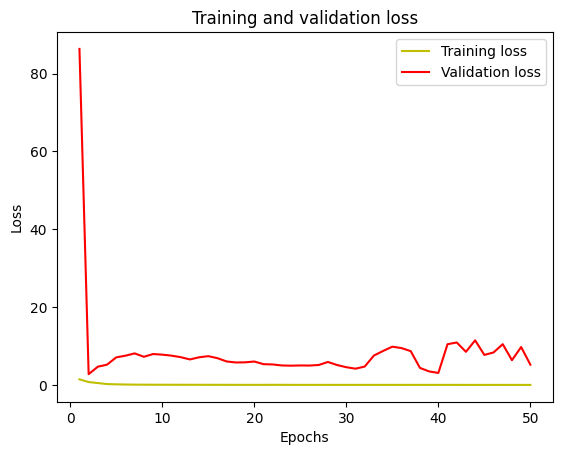

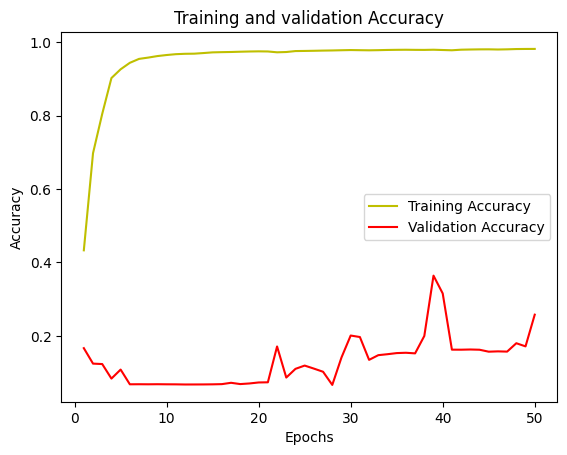

1/1 [==============================] - 1s 871ms/step


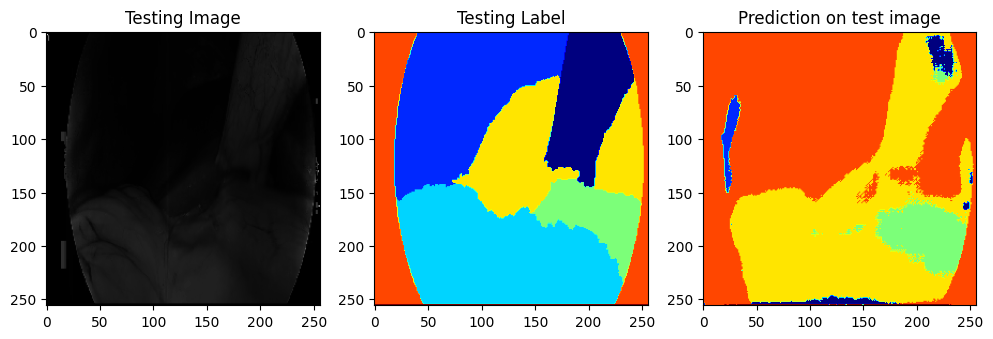

In [72]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [73]:
y_pred=model.predict(X_test)
y_pred.shape
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

y_true = y_test[:,:,:,0].flatten()
y_pred = y_pred_argmax.flatten()


2/2 [==============================] - 3s 442ms/step


In [74]:
from sklearn.metrics import f1_score
import numpy as np
# y_true = y_test[:,:,:,0].flatten()
# y_pred = y_pred_argmax.flatten()
f1 = f1_score(y_true, y_pred, average='weighted')
print("Mean F1 Score =", np.round(f1, 4))


from sklearn.metrics import f1_score, confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:\n', cm)

from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print('Classification report:\n', report)

Mean F1 Score = 0.173
Confusion matrix:
 [[ 32617      0      0  45400 300893  60552      2]
 [  6608  23483      0    619  96342 729777      6]
 [ 30404  15688     81  24731 434087  18213    502]
 [   367      0      0  83142  96071  36921      0]
 [  1411    354      0     88 163506 416509      0]
 [  1425   1360      0     30   2179 500710   1540]
 [  1017     56      0     27   1890   9811   7309]]
Classification report:
               precision    recall  f1-score   support

           0       0.44      0.07      0.13    439464
           1       0.57      0.03      0.05    856835
           2       1.00      0.00      0.00    523706
           3       0.54      0.38      0.45    216501
           4       0.15      0.28      0.20    581868
           5       0.28      0.99      0.44    507244
           6       0.78      0.36      0.50     20110

    accuracy                           0.26   3145728
   macro avg       0.54      0.30      0.25   3145728
weighted avg       0.50     

In [75]:
for class_index in range(n_classes):
    iou = calculate_iou(y_test, y_pred, class_index)
    print("IoU for class", class_index, ":", iou)

from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

IoU for class 0 : 0.06785369547489474
IoU for class 1 : 0.026859416694403365
IoU for class 2 : 0.00015466693144626948
IoU for class 3 : 0.2892942142548957
IoU for class 4 : 0.10804385031685092
IoU for class 5 : 0.2814516024770844
IoU for class 6 : 0.3298285198555957
Mean IoU = 0.15764086


In [76]:
dice_coefficients = []
for class_index in range(n_classes):
    dice_coefficient = calculate_dice_coefficient(y_test, y_pred, class_index)
    print("Dice coefficient for class", class_index, ":", dice_coefficient)
    dice_coefficients.append(dice_coefficient)
    
mean_dice_coefficient = sum(dice_coefficients) / len(dice_coefficients)
print("Mean Dice coefficient:", mean_dice_coefficient)

Dice coefficient for class 0 : 0.12708425463606027
Dice coefficient for class 1 : 0.05231371745290585
Dice coefficient for class 2 : 0.00030928602657186985
Dice coefficient for class 3 : 0.44876368955410784
Dice coefficient for class 4 : 0.19501728254880024
Dice coefficient for class 5 : 0.439269968421796
Dice coefficient for class 6 : 0.496046693135159
Mean Dice coefficient: 0.25125784168220017


In [79]:
model = dense_unet(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_cat, 
                    batch_size = 5, 
                    verbose=1, 
                    epochs=30,
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_178 (Conv2D)            (None, 256, 256, 64  640         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_179 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_178[0][0]']             
                                )                                                           

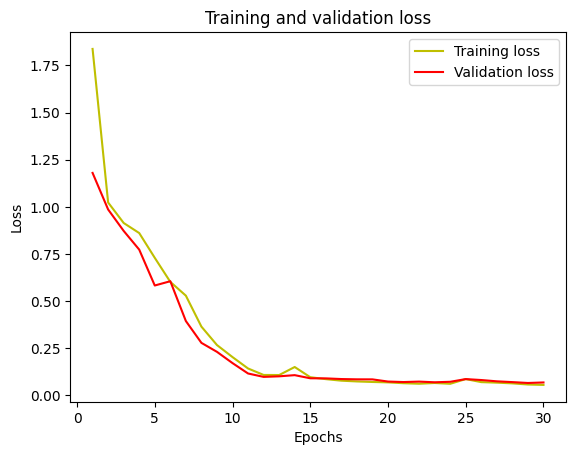

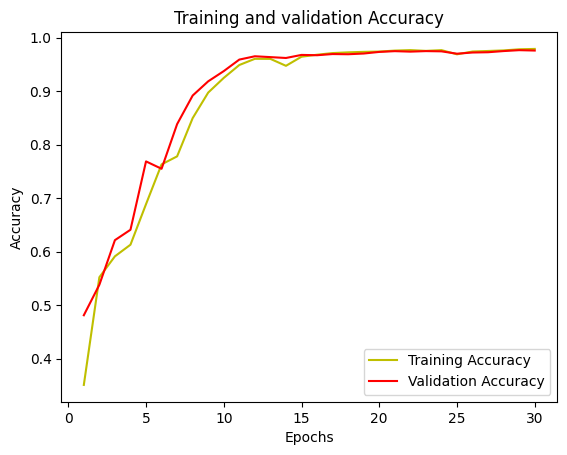

1/1 [==============================] - 0s 435ms/step


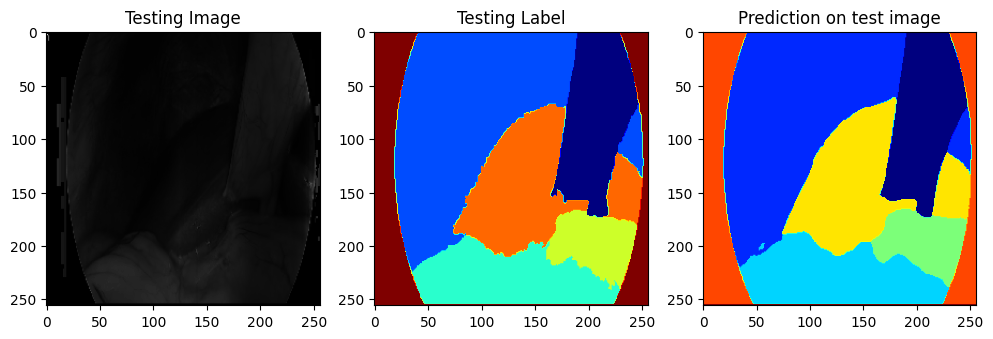

In [80]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [ ]:
y_pred=model.predict(X_test)
y_pred.shape
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

y_true = y_test[:,:,:,0].flatten()
y_pred = y_pred_argmax.flatten()

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
# y_true = y_test[:,:,:,0].flatten()
# y_pred = y_pred_argmax.flatten()
f1 = f1_score(y_true, y_pred, average='weighted')
print("Mean F1 Score =", np.round(f1, 4))


from sklearn.metrics import f1_score, confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:\n', cm)

from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print('Classification report:\n', report)

In [ ]:
for class_index in range(n_classes):
    iou = calculate_iou(y_test, y_pred, class_index)
    print("IoU for class", class_index, ":", iou)

from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
dice_coefficients = []
for class_index in range(n_classes):
    dice_coefficient = calculate_dice_coefficient(y_test, y_pred, class_index)
    print("Dice coefficient for class", class_index, ":", dice_coefficient)
    dice_coefficients.append(dice_coefficient)
    
mean_dice_coefficient = sum(dice_coefficients) / len(dice_coefficients)
print("Mean Dice coefficient:", mean_dice_coefficient)